# NODE21 - Exploratory Data Analysis (EDA)

- Entender estructura de `metadata.csv` y etiquetas.

- Verificar propiedades de imágenes preprocesadas.

- Visualizar ejemplos positivos/negativos con bounding boxes.

- Resumir estadísticas y proponer split train/val/test estratificado.

In [17]:
# Imports y paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import SimpleITK as sitk
import os

# Paths
PROJECT_ROOT = Path(os.getcwd()).parent if 'notebooks' in os.getcwd() else Path(os.getcwd())
DATA_DIR = PROJECT_ROOT / "dataset_node21" / "cxr_images" / "proccessed_data"
IMAGE_DIR = DATA_DIR / "images"
METADATA_PATH = DATA_DIR / "metadata.csv"

# Estética
sns.set_theme(style="whitegrid")

print(f"Project Root: {PROJECT_ROOT}")
print(f"Image Dir: {IMAGE_DIR}")
print(f"Metadata: {METADATA_PATH}")
print(f"Existe metadata: {METADATA_PATH.exists()}")
print(f"Existe images dir: {IMAGE_DIR.exists()}")

Project Root: /Users/manuela/Documents/facultad/aprendizaje_automatico
Image Dir: /Users/manuela/Documents/facultad/aprendizaje_automatico/dataset_node21/cxr_images/proccessed_data/images
Metadata: /Users/manuela/Documents/facultad/aprendizaje_automatico/dataset_node21/cxr_images/proccessed_data/metadata.csv
Existe metadata: True
Existe images dir: True


In [2]:
# Cargar metadata
meta = pd.read_csv(METADATA_PATH)
print(meta.shape)
meta.head()

(5224, 7)


,Unnamed: 0,height,img_name,label,width,x,y
0,0,94,n0239.mha,1,92,776,579
1,1,40,n0342.mha,1,27,223,642
2,2,111,n0996.mha,1,159,687,310
3,3,84,n0418.mha,1,81,343,510
4,4,69,n0538.mha,1,62,599,645


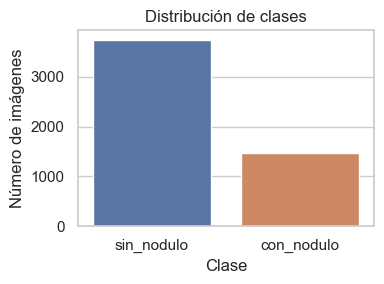

Positivos: 1476 (28.3%) | Negativos: 3748 (71.7%)


In [3]:
# Distribución de clases
label_counts = meta['label'].value_counts().sort_index()
class_map = {0: 'sin_nodulo', 1: 'con_nodulo'}
label_counts.index = label_counts.index.map(class_map)

plt.figure(figsize=(4,3))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette=['#4c72b0', '#dd8452'], legend=False)
plt.title('Distribución de clases')
plt.ylabel('Número de imágenes')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

pos_pct = 100 * label_counts['con_nodulo'] / label_counts.sum()
neg_pct = 100 * label_counts['sin_nodulo'] / label_counts.sum()
print(f"Positivos: {label_counts['con_nodulo']} ({pos_pct:.1f}%) | Negativos: {label_counts['sin_nodulo']} ({neg_pct:.1f}%)")

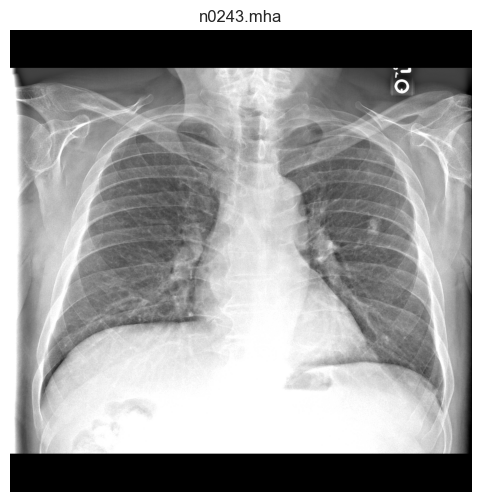

In [9]:
# Funciones utilitarias para imágenes

def load_mha(path: Path):
    img = sitk.ReadImage(str(path))
    arr = sitk.GetArrayFromImage(img)
    if arr.ndim == 3:
        arr = arr.squeeze()
    return arr, img


def plot_image_with_boxes(img_np, boxes=None, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img_np, cmap='gray')
    if boxes is not None and len(boxes) > 0:
        for (_, row) in boxes.iterrows():
            x, y, w, h = row[['x','y','width','height']]
            rect = plt.Rectangle((x, y), w, h, fill=False, color='lime', linewidth=1.5)
            plt.gca().add_patch(rect)
    plt.title(title or '')
    plt.axis('off')
    plt.show()

# Ejemplo aleatorio: cargar una imagen y verificar tamaño e intensidades
sample_row = meta.sample(1).iloc[0]
img_name = sample_row['img_name']
sample_img = IMAGE_DIR / img_name
img_np, img_obj = load_mha(sample_img)
plot_image_with_boxes(img_np, title=img_name)

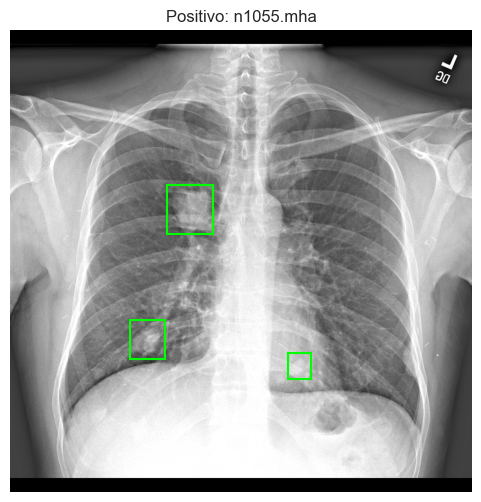

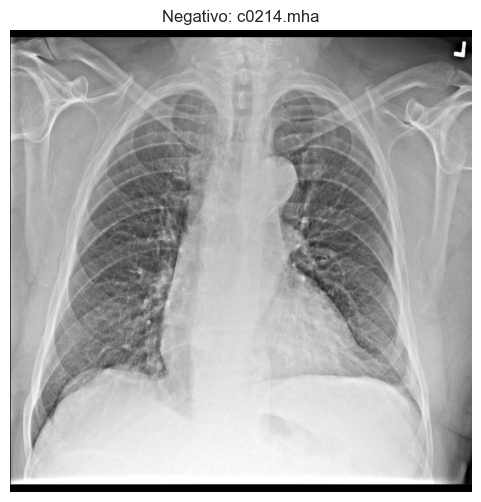

In [10]:
# Visualizar ejemplos positivos y negativos (aleatorios en cada ejecución)
pos_row = meta[meta['label'] == 1].sample(1).iloc[0]
neg_row = meta[meta['label'] == 0].sample(1).iloc[0]

# Positivo
pos_img_path = IMAGE_DIR / pos_row['img_name']
pos_img_np, _ = load_mha(pos_img_path)
pos_boxes = meta[meta['img_name'] == pos_row['img_name']]
plot_image_with_boxes(pos_img_np, pos_boxes, title=f"Positivo: {pos_row['img_name']}")

# Negativo
neg_img_path = IMAGE_DIR / neg_row['img_name']
neg_img_np, _ = load_mha(neg_img_path)
plot_image_with_boxes(neg_img_np, None, title=f"Negativo: {neg_row['img_name']}")

Distribución de nódulos por imagen (solo imágenes positivas):
  1 nódulo(s): 893 imágenes (78.7%)
  2 nódulo(s): 140 imágenes (12.3%)
  3 nódulo(s): 101 imágenes (8.9%)


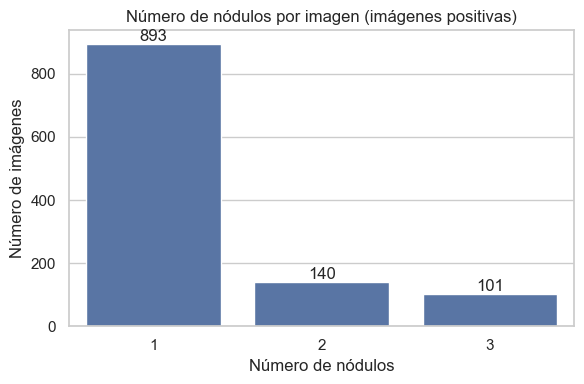


 Estadísticas de bounding boxes (1476 nódulos anotados):
             width       height
count  1476.000000  1476.000000
mean     57.371951    59.482385
std      23.146619    24.105510
min       1.000000    12.000000
25%      41.000000    42.750000
50%      52.000000    54.000000
75%      69.000000    72.000000
max     159.000000   187.000000


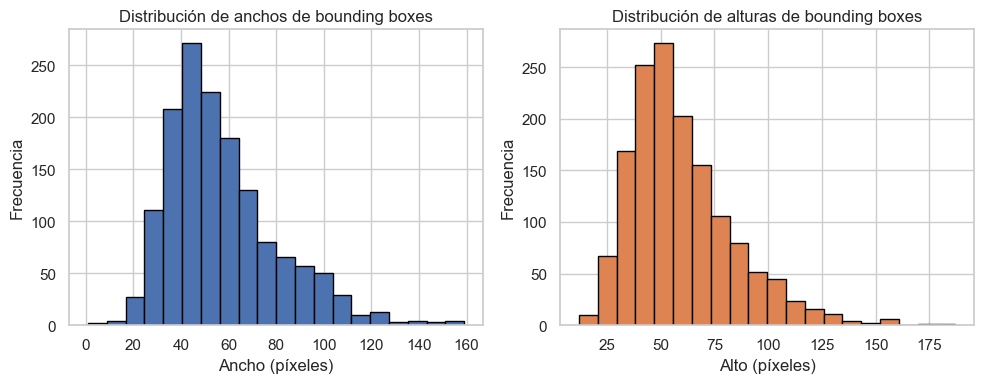

In [18]:
# Análisis de imágenes con múltiples nódulos
# Contar cuántos nódulos tiene cada imagen positiva
unique_pos_imgs = meta[meta['label'] == 1].groupby('img_name').size()

print("Distribución de nódulos por imagen (solo imágenes positivas):")
nodule_distribution = unique_pos_imgs.value_counts().sort_index()
for n_nodules, count in nodule_distribution.items():
    pct = 100 * count / len(unique_pos_imgs)
    print(f"  {int(n_nodules)} nódulo(s): {count} imágenes ({pct:.1f}%)")

# Gráfico mejorado (solo valores enteros)
plt.figure(figsize=(6,4))
ax = sns.countplot(x=unique_pos_imgs.values, color='#4c72b0')
plt.title('Número de nódulos por imagen (imágenes positivas)')
plt.xlabel('Número de nódulos')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=0)
# Añadir valores encima de las barras
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

# Dimensiones de bounding boxes (solo para nódulos reales, excluyendo width=0 y height=0)
bboxes_reales = meta[(meta['width'] > 0) & (meta['height'] > 0)]
print(f"\n Estadísticas de bounding boxes ({len(bboxes_reales)} nódulos anotados):")
print(bboxes_reales[['width','height']].describe())

# Visualizar distribución de tamaños
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(bboxes_reales['width'], bins=20, color='#4c72b0', edgecolor='black')
axes[0].set_title('Distribución de anchos de bounding boxes')
axes[0].set_xlabel('Ancho (píxeles)')
axes[0].set_ylabel('Frecuencia')

axes[1].hist(bboxes_reales['height'], bins=20, color='#dd8452', edgecolor='black')
axes[1].set_title('Distribución de alturas de bounding boxes')
axes[1].set_xlabel('Alto (píxeles)')
axes[1].set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

## Próximo paso: Generar splits train/test

El análisis EDA ha terminado. Ahora necesitas:

1. **Ejecutar `00_generate_splits.ipynb`** (una sola vez):
   - Genera splits train/test (80/20) estratificados
   - Los guarda en `data/splits/` como JSON
   - Estos splits se reutilizan en TODOS los modelos

2. **Luego**: Proceder con entrenamiento en `02_train_simplecnn.ipynb`

**Nota**: Los splits se generan con `random_state=42` para reproducibilidad. Se reutilizan en todos los modelos para comparación justa.

In [19]:
# Split train/test estratificado (80/20)
from sklearn.model_selection import train_test_split

unique_imgs = meta[['img_name','label']].drop_duplicates()
train_imgs, test_imgs = train_test_split(
    unique_imgs, 
    test_size=0.20, 
    stratify=unique_imgs['label'],
    random_state=42
)

print(f"Train: {len(train_imgs)} ({100*len(train_imgs)/len(unique_imgs):.1f}%) | Test: {len(test_imgs)} ({100*len(test_imgs)/len(unique_imgs):.1f}%)")
print(f"Total imágenes únicas: {len(unique_imgs)}")
print("\n Distribución en Train:")
train_dist = train_imgs['label'].value_counts(normalize=True).rename(lambda x: class_map[x])
for label, pct in train_dist.items():
    count = train_imgs['label'].value_counts()[1 if label == 'con_nodulo' else 0]
    print(f"  {label}: {count} ({100*pct:.1f}%)")

print("\n Distribución en Test:")
test_dist = test_imgs['label'].value_counts(normalize=True).rename(lambda x: class_map[x])
for label, pct in test_dist.items():
    count = test_imgs['label'].value_counts()[1 if label == 'con_nodulo' else 0]
    print(f"  {label}: {count} ({100*pct:.1f}%)")

print(f"\n Estratificación correcta: proporciones se mantienen entre train/test")

Train: 3905 (80.0%) | Test: 977 (20.0%)
Total imágenes únicas: 4882

 Distribución en Train:
  sin_nodulo: 2998 (76.8%)
  con_nodulo: 907 (23.2%)

 Distribución en Test:
  sin_nodulo: 750 (76.8%)
  con_nodulo: 227 (23.2%)

 Estratificación correcta: proporciones se mantienen entre train/test
